## Step 1: Data Collection and API Integration

### Food-101 Dataset

The **Food-101** dataset is a large-scale collection of food images designed for visual recognition tasks.  
It contains **101 categories** of food, with **1,000 images per class** — 750 for training and 250 for testing.  

Since the dataset was downloaded manually from the official [Food-101 website](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), the extracted directory structure looks like this:



<pre>

food-101/
├── images/
│   ├── apple_pie/
│   ├── pizza/
│   ├── sushi/
│   └── ...
└── meta/
    ├── train.json
    ├── test.json
    └── classes.txt

</pre>


Each image folder corresponds to a food category (e.g., `pizza`, `sushi`, `apple_pie`).  
The `train.json` and `test.json` files contain mappings of image paths to their corresponding labels.

In [1]:
import json
import os
import pandas as pd

# Load Food-101 train and test metadata
with open('../data/raw/food-101/meta/train.json') as f:
    train_data = json.load(f)
with open('../data/raw/food-101/meta/test.json') as f:
    test_data = json.load(f)

# Convert to DataFrame
train_list = [(img, label) for label, imgs in train_data.items() for img in imgs]
test_list = [(img, label) for label, imgs in test_data.items() for img in imgs]

train_df = pd.DataFrame(train_list, columns=['image_name', 'label'])
test_df = pd.DataFrame(test_list, columns=['image_name', 'label'])

# Load USDA dataset
usda_df = pd.read_csv("../data/raw/usda_food_data.csv")

# Normalize keys for better matching
usda_df["normalized"] = usda_df["description"].str.lower().str.replace(" ", "_").str.strip()
train_df["normalized_label"] = train_df["label"].str.lower().str.strip()

# Merge Food-101 with USDA nutritional info
merged_train = train_df.merge(usda_df, left_on="normalized_label", right_on="normalized", how="left")

# Save cleaned CSVs
merged_train.to_csv("../data/clean/train_cleaned.csv", index=False)
test_df.to_csv("../data/clean/test_cleaned.csv", index=False)

print("Data cleaning complete — saved train_cleaned.csv and test_cleaned.csv")

Data cleaning complete — saved train_cleaned.csv and test_cleaned.csv


In [2]:
train_df = pd.read_csv("../data/clean/train_cleaned.csv")
test_df = pd.read_csv("../data/clean/test_cleaned.csv")

print("Datasets successfully loaded")
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Datasets successfully loaded
Training set shape: (83250, 12)
Testing set shape: (25250, 2)


In [3]:
print("\nTraining Data Info:")
print(train_df.info())

print("\nFirst 5 rows of Training Data:")
display(train_df.head())

print("\nNumber of unique labels (food classes):", train_df['label'].nunique())
print("\nSample labels:", train_df['label'].unique()[:10])


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83250 entries, 0 to 83249
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image_name        83250 non-null  object 
 1   label             83250 non-null  object 
 2   normalized_label  83250 non-null  object 
 3   query             59250 non-null  object 
 4   fdcId             59250 non-null  float64
 5   description       59250 non-null  object 
 6   dataType          59250 non-null  object 
 7   calories          59250 non-null  float64
 8   protein           59250 non-null  float64
 9   fat               59250 non-null  float64
 10  carbohydrates     58500 non-null  float64
 11  normalized        59250 non-null  object 
dtypes: float64(5), object(7)
memory usage: 7.6+ MB
None

First 5 rows of Training Data:


,image_name,label,normalized_label,query,fdcId,description,dataType,calories,protein,fat,carbohydrates,normalized
0,churros/1004234,churros,churros,churros,2708070.0,Churros,Survey (FNDDS),419.0,6.05,22.21,48.87,churros
1,churros/1004234,churros,churros,churros,2580402.0,CHURROS,Branded,339.0,4.84,12.90,51.60,churros
2,churros/1013460,churros,churros,churros,2708070.0,Churros,Survey (FNDDS),419.0,6.05,22.21,48.87,churros
3,churros/1013460,churros,churros,churros,2580402.0,CHURROS,Branded,339.0,4.84,12.90,51.60,churros
4,churros/1016791,churros,churros,churros,2708070.0,Churros,Survey (FNDDS),419.0,6.05,22.21,48.87,churros



Number of unique labels (food classes): 101

Sample labels: ['churros' 'hot_and_sour_soup' 'samosa' 'sashimi' 'pork_chop'
 'spring_rolls' 'panna_cotta' 'beef_tartare' 'greek_salad' 'foie_gras']


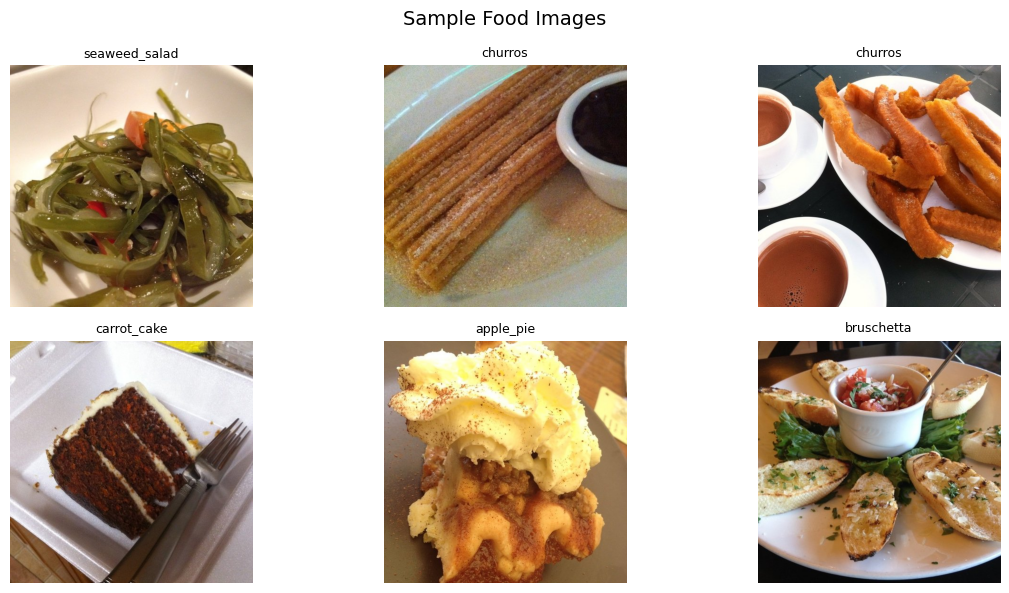

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images(df, base_path="../data/raw/food-101/images", n=6):
    sample_rows = df.sample(n)
    fig, axes = plt.subplots(2, n//2, figsize=(12, 6))
    axes = axes.flatten()

    for i, (_, row) in enumerate(sample_rows.iterrows()):
        img_path = os.path.join(base_path, f"{row['image_name']}.jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(row['label'], fontsize=9)
            axes[i].axis("off")
        else:
            axes[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
            axes[i].set_axis_off()

    plt.suptitle("Sample Food Images", fontsize=14)
    plt.tight_layout()
    plt.show()

show_sample_images(train_df)

In [5]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 224
BATCH_SIZE = 32

# Encode string labels to integers
label_encoder = LabelEncoder()
train_df["label_encoded"] = label_encoder.fit_transform(train_df["label"])
test_df["label_encoded"] = label_encoder.transform(test_df["label"])

# Save the encoder mapping for later use
import json
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
with open("../data/clean/label_map.json", "w") as f:
    json.dump({k: int(v) for k, v in label_map.items()}, f)

def get_image_path(image_name):
    return os.path.join("../data/raw/food-101/images", image_name + ".jpg")

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = preprocess_input(image)
    return image, label

# Add image paths
train_df["image_path"] = train_df["image_name"].apply(get_image_path)
test_df["image_path"] = test_df["image_name"].apply(get_image_path)

# Build TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_df["image_path"], train_df["label_encoded"]))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_df["image_path"], test_df["label_encoded"]))
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Datasets ready for training and testing!")

Datasets ready for training and testing!
